In [1]:
# for export pdf
import matplotlib.pyplot
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

_Notes on generate pdf:_
```bash
jupyter nbconvert --to pdf 02_firedrake_intro.ipynb
```
<!--
1. 本文档 pdf 版本生成
```bash
jupyter nbconvert --to pdf 02_firedrake_intro.ipynb
```
2. 查看模板路径: 一般位于 `<data-path>/nbconvert/templates/latex`
```bash
$ jupyter --paths
config:
    /home/yzz/.jupyter
    /home/yzz/software/firedrake-mini-petsc/etc/jupyter
    /usr/local/etc/jupyter
    /etc/jupyter
data:
    /home/yzz/.local/share/jupyter
    /home/yzz/software/firedrake-mini-petsc/share/jupyter
    /usr/local/share/jupyter
    /usr/share/jupyter
runtime:
    /home/yzz/.local/share/jupyter/runtime
```
3. pdf title 和 author: 编辑源文件
-->

Check for new version at https://github.com/lrtfm/notes-for-firedrake/blob/main/02_firedrake_intro.ipynb

Firedrake 是基于弱形式求解偏微分方程的工具: 根据用户定义的有限元空间和变分形式, Firedrake 自动生成代码组装线性或非线性方程组, 然后使用 PETSc 进行求解.

# Solving Poisson equation

## Dirichlet Problem

Considering the following Poisson equation
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         u &= g_D &&\quad{\rm on} \quad \partial\Omega_D, \\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega_N,
\end{aligned}
\end{equation}
where $\partial\Omega_D\cap\partial\Omega_N = \partial\Omega$, and $\int_{\partial\Omega_D} {\rm d}s \ne 0$.

Define __trial__ and __test__ function space

\begin{equation}
\begin{aligned}
H_E^1 := \{u \in H^1 \,|\, u = g_D \ \ \text{on}\ \ \partial\Omega_D\},\\
H^1_{E_0} := \{u \in H^1 \,|\, u = 0 \ \ \text{on}\ \ \partial\Omega_D\}\\
\end{aligned}
\end{equation}

The __variational form__ is

Find $u \in H_E^1$, such that
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega_N} g_N v \qquad \forall v \in H^1_{E_0}.
\end{equation}

### A simple example

Now, we solve possion problem in domain $\Omega = (0, 1)\times(0, 1)$.
Assume $\partial\Omega_N = \emptyset, \partial\Omega_D = \partial\Omega$ and $g_D = 0$ (homogeneous Dirichlet boundary condition).
In addition, let the source term be $f = \sin(\pi x)\sin(\pi y)$. 

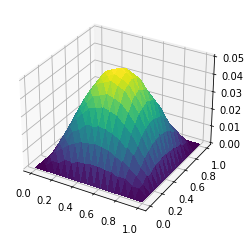

In [2]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)   # Build mesh on the domain
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)        # define FE space

u, v = TrialFunction(V), TestFunction(V)            # define trial and test function 
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                                  # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')
solve(a == L, u_h, bcs=bc)          # We will introduce other ways to code in the following.

fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

### Builtin meshes in Firedrake

In [3]:
from firedrake import utility_meshes
from pprint import pprint

print('List of builtin meshes:')
for i, name in enumerate(utility_meshes.__all__):
    print(f'  {name:<25s}', end='')
    if (i+1)%3 == 0:
        print('')

List of builtin meshes:
  IntervalMesh               UnitIntervalMesh           PeriodicIntervalMesh     
  PeriodicUnitIntervalMesh   UnitTriangleMesh           RectangleMesh            
  TensorRectangleMesh        SquareMesh                 UnitSquareMesh           
  PeriodicRectangleMesh      PeriodicSquareMesh         PeriodicUnitSquareMesh   
  CircleManifoldMesh         UnitDiskMesh               UnitBallMesh             
  UnitTetrahedronMesh        BoxMesh                    CubeMesh                 
  UnitCubeMesh               PeriodicBoxMesh            PeriodicUnitCubeMesh     
  IcosahedralSphereMesh      UnitIcosahedralSphereMesh  OctahedralSphereMesh     
  UnitOctahedralSphereMesh   CubedSphereMesh            UnitCubedSphereMesh      
  TorusMesh                  CylinderMesh             

__How to find the doc or help for functions/classes__

1. `?<fun-name>`
2. `help(<fun-name>)`

In [4]:
from firedrake import utility_meshes
help(utility_meshes.CubeMesh)

Help on cython_function_or_method in module firedrake.utility_meshes:

CubeMesh(nx, ny, nz, L, reorder=None, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7fb82a043110>, name='firedrake_default', distribution_name=None, permutation_name=None)
    Generate a mesh of a cube
    
    :arg nx: The number of cells in the x direction
    :arg ny: The number of cells in the y direction
    :arg nz: The number of cells in the z direction
    :arg L: The extent in the x, y and z directions
    :kwarg reorder: (optional), should the mesh be reordered?
    :kwarg comm: Optional communicator to build the mesh on (defaults to
        COMM_WORLD).
    :kwarg name: Optional name of the mesh.
    :kwarg distribution_name: the name of parallel distribution used
           when checkpointing; if `None`, the name is automatically
           generated.
    :kwarg permutation_name: the name of entity permutation (reordering) used
           when checkpointing; if `None`, the name is 

### UFL 表达式

#### 算子

DOC: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#tensor-algebra-operators)

1. `dot`
    
    张量缩并, `dot(u, v)` 对 `u` 的最后一个维度和 `v` 的第一个维度做缩并.
    
2. `inner`
    
    张量内积(分量对应乘积之和). 对第二个张量取复共轭.
    
3. `grad` and `nabla_grad`
    1. `grad`
        
        对张量求导, 新加维度为最后一个维度.
        
        1. scalar
            $$
            {\rm grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
            $$
            
        2. vector
            $$
            {\rm grad}({\bf v}) = \nabla {\bf v} = \frac{\partial v_i}{\partial x_j}{\bf e}_i \otimes {\bf e}_j
            $$
            
        3. tensor

            设 $\bf T$ 为秩为 $r$ 的张量, 那么
            $$
            {\rm grad}({\bf T}) = \nabla {\bf T} = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}\otimes {\bf e}_{i}
            $$
            其中 $\ell$ 是长度为 $r$ 的多指标 (multi-index).
            
    2. `nabla_grad`

        **类似 `grad`, 不过新加维度为第一个维度**
        
        1. scalar (same with `grad`)
            $$
            {\rm nabla\_grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
            $$
        2. vector
            $$
            {\rm nabla\_grad}({\bf v}) = (\nabla {\bf v})^T = \frac{\partial v_j}{\partial x_i}{\bf e}_i \otimes {\bf e}_j
            $$
        3. tensor

            设 $\bf T$ 为秩为 $r$ 的张量, 那么
            $$
            {\rm nabla\_grad}({\bf T}) = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{i}\otimes {\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}
            $$
            
4. `div` and `nabla_div`
    1. `div`

        **对最后一个维度的偏导数进行缩并.**

        
        设 $\bf T$ 为秩为 $r$ 的张量, 那么
        $$
        {\rm div}({\bf T}) = \sum_i\frac{\partial {\bf T}_{\ell_1\ell_2\cdots\ell_{r-1} i}}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_{r-1}}
        $$
        
    2. `nabla_div`

        **类似 `div`, 不过对第一个维度的偏导数进行缩并.**

5. 两个表达式:
    1. $(u\cdot\nabla) v$ → `dot(u, nabla_grad(v))` or `dot(grad(v), u)`
    2. $\Delta u$ → `div(grad(u))`

#### 非线性函数

https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#basic-nonlinear-functions

+ `abs`, `sign`
+ `pow`, `sqrt`
+ `exp`, `ln`
+ `cos`, `sin`, ...
+ ...

#### Measures

1. `dx`: the interior of the domain $\Omega$ (`dx`, cell integral);
2. `ds`: the boundary $\partial\Omega$ of $\Omega$ (`ds`, exterior facet integral);
3. `dS`: the set of interior facets $\Gamma$ (`dS`, interior facet integral).

在区域内部的边界上积分时, 需要使用 `dS` 并使用限制算子 `+` 或 `-`, 如:

```python
a = u('+')*v('+')*dS
```

#### Check UFL form

In [5]:
from firedrake import *
import ufl

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
V = FunctionSpace(test_mesh, 'CG', degree=1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx + inner(Constant(0), v)*dx

print(ufl.formatting.printing.tree_format(a))

Form:
    Integral:
        integral type: cell
        subdomain id: everywhere
        integrand:
            Conj
                Inner
                (
                    Grad
                        Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fb81a699fa0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 7)), 0, None)
                    Grad
                        Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fb81a699fa0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 7)), 1, None)
                )
    Integral:
        integral type: cell
        subdomain id: everywhere
        integrand:
            Product
            (
                Constant(FiniteElement('Real', None, 0), 12)
                Conj
                    Argument(WithGeometry(FunctionSpace(<firedrake.

### 函数空间创建


+ FunctionSpace 标量函数空间
+ VectorFunctionSpace 向量函数空间
+ MixedFunctionSpace 混合空间

支持的单元类型: CG, DG, RT, BDM, ... (https://firedrakeproject.org/variational-problems.html#supported-finite-elements)

### 线性方程组参数设置

#### 三种求解方程组 Coding 方式

仍然以上述 Poisson 方程为例: [Possion Example](possion_example1.py)

可以使用 `%load` 加载文件内容到 notebook 中
```pyhon
%load possion_example1.py
```

In [6]:
# %load possion_example1.py
from firedrake import *
from firedrake.petsc import PETSc

methods = ['solve', 
           'assemble', 
           'LinearVariationalSolver']

# Get commandline args
opts = PETSc.Options()
case_index = opts.getInt('case_index', default=0)
if case_index < 0 or case_index > 2:
    raise Exception('Case index must be in [0, 2]')
    
case = methods[case_index]

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                    # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')

if case == 'solve':
    PETSc.Sys.Print('Case: solve')
    # solve(a == L, u_h, bcs=bc)
    solve(a == L, u_h, bcs=bc,
          solver_parameters={           # parameters for solving linear system
              # 'ksp_view': None,
              'ksp_type': 'preonly', 
              'pc_type': 'lu',
              'pc_factor_mat_solver_type': 'mumps'
          },
          options_prefix='test'         # prefix of the command line options
         )
    

elif case == 'assemble':
    PETSc.Sys.Print('Case: assemble')
    A = assemble(a, bcs=bc)
    b = assemble(L, bcs=bc)
    solve(A, u_h, b,
          options_prefix='test'
         )

elif case == 'LinearVariationalSolver':
    PETSc.Sys.Print('Case: LinearVariationalSolver')
    problem = LinearVariationalProblem(a, L, u_h, bcs=bc)
    solver = LinearVariationalSolver(problem, 
                                     solver_parameters={
                                         # 'ksp_view': None,
                                         'ksp_monitor': None,
                                         'ksp_converged_reason': None,
                                         'ksp_type': 'cg',
                                         'pc_type': 'none'
                                     }, 
                                     options_prefix='test')

    solver.solve()
else:
    raise Exception(f'Unknow case: {case}')

pvd_name = 'pvd/poisson_example.pvd'
File(pvd_name).write(u_h)
print(f'Solution saved in `{pvd_name}`!')

Case: solve
Solution saved in `pvd/poisson_example.pvd`!


+ KSP [scalable linear equations solvers, Krylov subspace solver with preconditioner](https://petsc.org/main/docs/manualpages/KSP/index.html) 
    
    参数: https://petsc.org/main/docs/manual/ksp/#tab-kspdefaults

+ PC
    
    参数: https://petsc.org/main/docs/manual/ksp/#tab-pcdefaults
    
    + 外部包 pc 参数: https://petsc.org/main/docs/manual/ksp/#tab-externaloptions

#### 命令行参数

__参数说明__

1. `mat_type`: `aij` 或 `matfree`
1. `ksp_type`: 设置迭代法
2. `pc_type`: 设置预处理方式
3. `pc_factor_mat_solver_type`: 设置使用做矩阵分解的包
3. `ksp_monitor`: 输出每步迭代的残差
4. `ksp_view`: 迭代完成后输出 ksp 的设置等内容
5. `ksp_converged_reason`: 输出收敛或不收敛的原因
6. `ksp_error_if_not_converged`: 不收敛时, 输出错误信息, 并停止. https://petsc.org/release/docs/manualpages/KSP/KSPSetErrorIfNotConverged/

__LU 分解参数设置__

Ref: https://petsc.org/release/src/dm/impls/stag/tutorials/ex4.c.html

```
-ksp_type preonly -pc_type lu -pc_factor_mat_solver_type mumps  
```

这里 `pc_factor_mat_solver_type` 设置 LU 分解使用的 package (如 petsc, mumps, umfpack, superlu).
其他选项见: https://petsc.org/release/docs/manualpages/Mat/MatSolverType/

__多重网格__

https://nbviewer.org/github/firedrakeproject/firedrake/blob/master/docs/notebooks/07-geometric-multigrid.ipynb

__终端演示__: 设置命令行参数控制线性方程组的求解

```bash
python possion_example1.py -case solve \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type cg -pc_type jacobi

python possion_example1.py -case assemble \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type gmres -pc_type none

python possion_example1.py -case LinearVariationalSolver \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type minres -pc_type none
```

### 数值积分公式

#### 查看数值积分公式

In [7]:
import FIAT
import finat
from pprint import pprint

ref_cell = FIAT.reference_element.UFCTriangle()

ret = {}
for i in range(0, 4):
    qrule = finat.quadrature.make_quadrature(ref_cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    
pprint(ret)

{0: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 1: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 2: {'points': array([[0.16666667, 0.16666667],
       [0.16666667, 0.66666667],
       [0.66666667, 0.16666667]]),
     'weights': array([0.16666667, 0.16666667, 0.16666667])},
 3: {'points': array([[0.65902762, 0.23193337],
       [0.65902762, 0.10903901],
       [0.23193337, 0.65902762],
       [0.23193337, 0.10903901],
       [0.10903901, 0.65902762],
       [0.10903901, 0.23193337]]),
     'weights': array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333])}}


#### 显示选择积分公式

In [8]:
import logging

# Disable warnings. If we do not do this, there will be warnings:
#     UFL:WARNING Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
level = logging.getLogger().level
set_log_level(CRITICAL) # Disable warnings


mesh = RectangleMesh(nx=8, ny=8, Lx=1, Ly=1)
V = FunctionSpace(mesh, 'CG', 1)
cell = V.finat_element.cell

x, y = SpatialCoordinate(mesh)
f = x**3 + y**4 + x**2*y**2

for i in range(0, 5):
    qrule = finat.quadrature.make_quadrature(ref_cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    v = assemble(f*dx(rule=qrule))
    print(f'degree={i}, v = {v}', )

print('Default:  v =', assemble(f*dx(rule=None)))

# restore the log level
set_log_level(level) # restore log level

degree=0, v = 0.5579329125675148
degree=1, v = 0.5579329125675148
degree=2, v = 0.5611099431544168
degree=3, v = 0.5611100938585061
degree=4, v = 0.5611111111111102
Default:  v = 0.5611111111111102


#### 自定义数值积分

In [9]:
from firedrake import *
import FIAT
import finat
import numpy as np

ref_cell = FIAT.reference_element.UFCTriangle()
print('vertices:', ref_cell.vertices)

point_set = finat.quadrature.PointSet(ref_cell.vertices)
weights = [1/6, 1/6, 1/6]

qrule = finat.quadrature.QuadratureRule(point_set, weights)


print("points: ", qrule.point_set.points)
print("weights: ", qrule.weights)

mesh = RectangleMesh(nx=8, ny=8, Lx=1, Ly=1)
x = SpatialCoordinate(mesh)
print("integral of x[0] on domain by default rule: ", assemble(x[0]*dx))
print("integral of x[0] on domain by new def-rule: ", assemble(x[0]*dx(rule=qrule)))

vertices: ((0.0, 0.0), (1.0, 0.0), (0.0, 1.0))
points:  [[0. 0.]
 [1. 0.]
 [0. 1.]]
weights:  [0.16666667 0.16666667 0.16666667]


UFL:WARNING Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
UFL:WARNING Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.


integral of x[0] on domain by default rule:  0.49999999999999956
integral of x[0] on domain by new def-rule:  0.4999999999999957


### Dirichlet bounary conditions

#### Tags of the boundaries of builtin meshes

`RectangleMesh`:
  
* 1: plane x == 0
* 2: plane x == Lx
* 3: plane y == 0
* 4: plane y == Ly

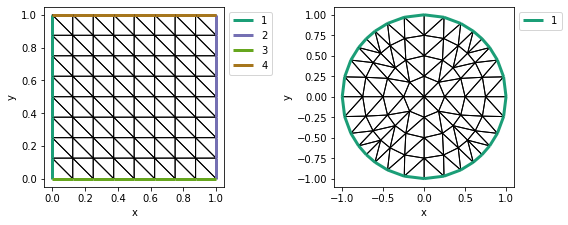

In [10]:
from firedrake import *
import matplotlib.pyplot as plt


def plot_mesh_with_label(mesh, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=[4, 4])
    triplot(mesh, axes=axes, boundary_kw={'lw': 3})
    axes.set_aspect(aspect='equal')
    # ax.set_axis_off()
    axes.legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes.set_xlabel('x')
    axes.set_ylabel('y')

N = 8
rect_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
circ_mesh = UnitDiskMesh(2)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_mesh_with_label(rect_mesh, axes=ax[0])
plot_mesh_with_label(circ_mesh, axes=ax[1])
fig.tight_layout()

#### Set Dirichlet boundary conditions

In [11]:
N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)

g = x*2 + y*2
V = FunctionSpace(test_mesh, 'CG', degree=1)


def trisurf_bdy_condition(V, g, sub_domain, axes=None):
    bc = DirichletBC(V, g=g, sub_domain=sub_domain)
    g = Function(V)
    bc.apply(g)

    trisurf(g, axes=axes)
    if axes:
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.set_title(sub_domain)

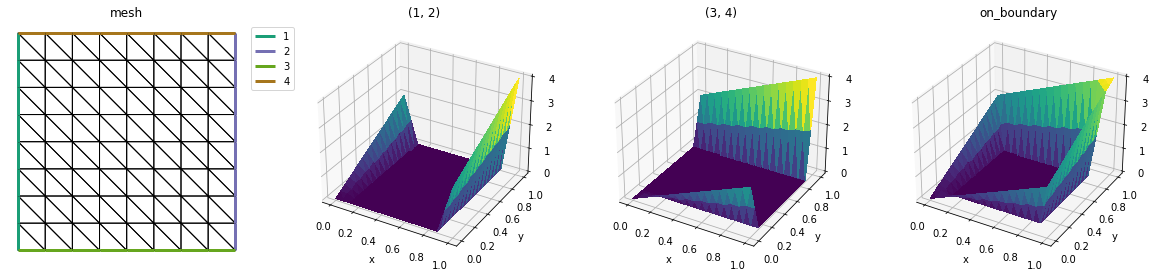

In [12]:
# plot the mesh and boundry conditons
fig, ax = plt.subplots(1, 4, figsize=[16, 4], subplot_kw=dict(projection='3d'))
ax = ax.flat

ax[0].remove()
ax[0] = fig.add_subplot(1, 4, 1)
plot_mesh_with_label(test_mesh, ax[0])
ax[0].set_title('mesh')
ax[0].axis('off')

sub_domains = [(1, 2), (3, 4), 'on_boundary']
for i in range(3):
    trisurf_bdy_condition(V, g=g, sub_domain=sub_domains[i], axes=ax[i+1])
fig.tight_layout()

#### `sub_domain` of  `DirichletBC` 

The following comments are copy from `firedrake/bcs.py`
```python
# Define facet, edge, vertex using tuples:
# Ex in 3D:
#           user input                                                         returned keys
# facet  = ((1, ), )                   ->     ((2, ((1, ), )), (1, ()),         (0, ()))
# edge   = ((1, 2), )                  ->     ((2, ()),        (1, ((1, 2), )), (0, ()))
# vertex = ((1, 2, 4), )               ->     ((2, ()),        (1, ()),         (0, ((1, 2, 4), ))
#
# Multiple facets:
# (1, 2, 4) := ((1, ), (2, ), (4,))   ->     ((2, ((1, ), (2, ), (4, ))), (1, ()), (0, ()))
#
# One facet and two edges:
# ((1,), (1, 3), (1, 4))              ->     ((2, ((1,),)), (1, ((1,3), (1, 4))), (0, ()))
```

### [Gmsh](https://gmsh.info/) 网格边界设置

需要在 gmsh 中给相应的边界加上标签 (Physical Tag)

_gmsh gui 演示_: 生成如下 `geo` 文件和 `msh` 文件

File: `gmsh/rectangle.geo`
```geo
// Gmsh project created on Tue Sep 30 15:09:53 2022
SetFactory("OpenCASCADE");
//+
Rectangle(1) = {0, 0, 0, 1, 1, 0};
//+
Physical Curve("lower", 1) = {1};
//+
Physical Curve("upper", 2) = {3};
//+
Physical Curve("left", 3) = {4};
//+
Physical Curve("right", 4) = {2};
//+
Physical Surface("domain", 1) = {1};
```

Gmsh file: `gmsh/rectangle.msh`

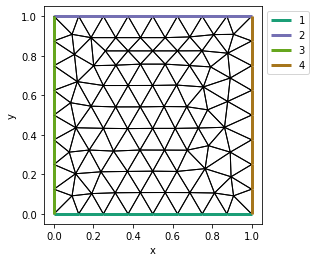

In [13]:
# opts = PETSc.Options()
# opts.insertString('-dm_plex_gmsh_mark_vertices True')

gmsh_mesh = Mesh('gmsh/rectangle.msh')
plot_mesh_with_label(gmsh_mesh)

_使用 gmsh 的 python SDK_: [gmsh](https://pypi.org/project/gmsh/) 或者 [pygmsh](https://pypi.org/project/pygmsh/)

example: [make_mesh_circle_in_rect.py](make_mesh_circle_in_rect.py)

In [14]:
from make_mesh_circle_in_rect import make_circle_in_rect

Info    : Writing 'gmsh/circle_in_rect.msh'...
Info    : Done writing 'gmsh/circle_in_rect.msh'


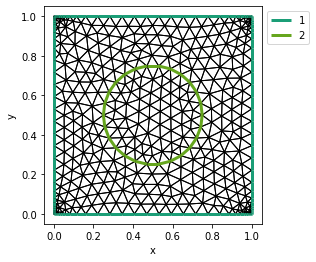

In [15]:
h = 1/16
filename = 'gmsh/circle_in_rect.msh'
make_circle_in_rect(h, filename, p=3, gui=False)

cr_mesh = Mesh(filename)
plot_mesh_with_label(cr_mesh)

## 纯 Neumann 边界条件

求解如下 Poisson 方程
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega,
\end{aligned}
\end{equation}

__变分问题__

求 $u \in H^1$, 且 $\int_\Omega u = 0$ 使得
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega} g_N v \qquad \forall v \in H^1.
\end{equation}

__兼容性条件__

$$
\int_\Omega f v + \int_{\partial\Omega} g_N v = 0
$$

### Use nullspace of solve

通过 nullspace 求出的解 `u_h` 并不满足积分为 0, 而是其对应的解向量的范数最小, 所以我们需要做后处理得到积分为 0 的解:

```python
s = assemble(u_h*dx)/assemble(Constant(1)*dx(domain=mesh)
u_h.assign(u_h - s)
```

Reference:

1. https://petsc.org/release/docs/manual/ksp/#solving-singular-systems
2. https://petsc.org/release/docs/manualpages/KSP/KSPSolve/
3. https://petsc.org/release/docs/manualpages/Mat/MatSetNullSpace/

    Residual norms for test1_ solve.
    0 KSP Residual norm 9.134205437239e-02 
    1 KSP Residual norm 8.621078780009e-13 
    Residual norms for test2_ solve.
    0 KSP Residual norm 9.134205437239e-02 
    1 KSP Residual norm 4.291755926117e-16 


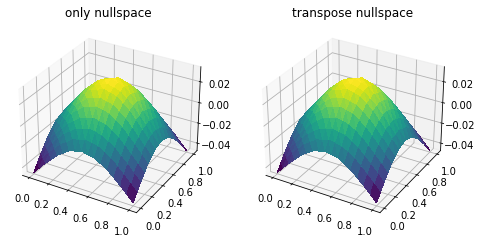

In [16]:
N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

subdomain_id = None # None for all boundray, 或者单个编号 如 1, 或者使用 list 或 tuple 如: (1, 2)

if False:
    # 不满足兼容性条件
    g = Constant(1)
else:
    # 满足兼容性条件
    length = assemble(1*ds(domain=test_mesh, subdomain_id=subdomain_id))
    g = Constant(-assemble(f*dx)/length)
    # g = Constant(-1/pi**2)

V = FunctionSpace(test_mesh, 'CG', degree=1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx + inner(g, v)*ds(subdomain_id=subdomain_id)

u1_h = Function(V, name='u1_h')

nullspace = VectorSpaceBasis(constant=True)

solve(a == L, u1_h, 
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test1',
      nullspace=nullspace, 
      transpose_nullspace=None)

u2_h = Function(V, name='u2_h')
solve(a == L, u2_h,
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test2',
      nullspace=nullspace, 
      transpose_nullspace=nullspace)

# 通过 nullspace 求出的解并不满足积分为 0, 需要做后处理
omega = assemble(Constant(1)*dx(domain=test_mesh))
s1 = assemble(u1_h*dx)/omega
u1_h.dat.data_with_halos[:] = u1_h.dat.data_ro_with_halos[:] - s1

s2 = assemble(u2_h*dx)/omega
u2_h.dat.data_with_halos[:] = u2_h.dat.data_ro_with_halos[:] - s2

fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts1 = trisurf(u1_h, axes=ax[0])
title1 = ax[0].set_title('only nullspace')
ts2 = trisurf(u2_h, axes=ax[1])
title2 = ax[1].set_title('transpose nullspace')

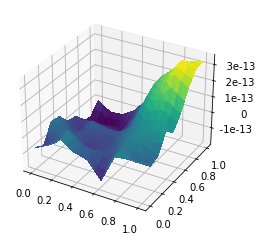

In [17]:
fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
err = Function(u1_h).assign(u1_h - u2_h)
trisurf(err, axes=ax)

# The z ticklabel do not show properly, when the values are small.
# we set the major formatter to make it show correctly
fmt = lambda x, pos: f'{x:10g}'
ax.zaxis.set_major_formatter(fmt)

# ax.ticklabel_format(axis='z', style='plain') # may work for not too small values

### Using Lagrange multiplier

<!--__极值问题__
求 $u \in H^1 $ 满足
\begin{equation}
\begin{aligned}
    & u = \arg\min J(u)\\
    & J(u) = \frac12\int_\Omega |\nabla u|^2 - \int_\Omega f u - \int_{\partial\Omega} g_N u\\
    &\int_\Omega u = 0
\end{aligned}
\end{equation}

__等价问题__
\begin{equation}
\begin{aligned}
    & u, \mu = \arg\min \tilde J(u, \mu)\\
    & \tilde J(u, \lambda) = J(u) + \mu \int_\Omega u, \quad \mu\in \mathbb{R}\\
\end{aligned}
\end{equation}
-->

__变分问题__

求 $u\in H^1, \mu \in R$ 使得 
\begin{equation}
\begin{aligned}
    & \int_\Omega \nabla u \cdot \nabla v + \mu \int_\Omega v - \int_\Omega f v - \int_{\partial\Omega} g_N v = 0, \quad\forall \in H^1 \\
    & \eta \int_\Omega u = 0,\quad \forall \eta \in \mathbb{R}\\
\end{aligned}
\end{equation}

In [18]:
# %load possion_neumann_lagrange.py
from firedrake import *
from firedrake.petsc import PETSc

opts = PETSc.Options()
N = opts.getInt('N', default=8)
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)

x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

subdomain_id = None
length = assemble(1*ds(domain=test_mesh, subdomain_id=subdomain_id))
g = Constant(-assemble(f*dx)/length)
# g = Constant(-1/pi**2)

V = FunctionSpace(test_mesh, 'CG', degree=1)
R = FunctionSpace(test_mesh, 'R', 0)

W = MixedFunctionSpace([V, R]) # or W = V*R

u, mu = TrialFunction(W)
v, eta = TestFunction(W)

a = inner(grad(u), grad(v))*dx + inner(mu, v)*dx + inner(u, eta)*dx
L = inner(f, v)*dx + inner(g, v)*ds(subdomain_id=subdomain_id)

w_h = Function(W)
solve(a == L, w_h,      
      solver_parameters={
          # 'mat_type': 'nest',
          # 'ksp_view': None,
          # 'pc_type': 'fieldsplit',
          # 'ksp_monitor': None,
      },
      options_prefix='test')

u_h, mu_h  = w_h.split()

filename = 'pvd/u_h_neumann.pvd'
PETSc.Sys.Print(f'Write pvd file: {filename}')
File(filename).write(u_h)

firedrake:WARNING Real block detected, generating Schur complement elimination PC


Write pvd file: pvd/u_h_neumann.pvd


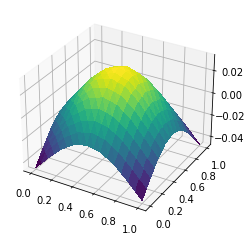

In [19]:
fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

__终端演示__

```bash
$ python possion_neumann_lagrange.py -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 1.747929427611e-01
    2 KSP Residual norm 1.071502741145e-14
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd

$ mpiexec -n 2 python possion_neumann_lagrange.py \
    -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 2.085403806063e-02
    2 KSP Residual norm 9.317076546546e-16
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd
```

## 计算收敛阶

+ 和真解对比
+ 和参考解对比
+ 相邻三层之间对比 (Cauchy 序列): [possion_convergence.py](possion_convergence.py)

### 生成网格序列

```python
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(test_mesh, refinement_levels=4)
```

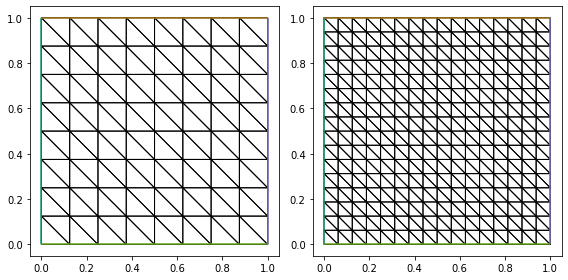

In [20]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(base, refinement_levels=3)

n = len(meshes)
m = min(2, n)
fig, ax = plt.subplots(1, m, figsize=[4*m, 4])
for i in range(m):
    triplot(meshes[i], axes=ax[i])
fig.tight_layout()

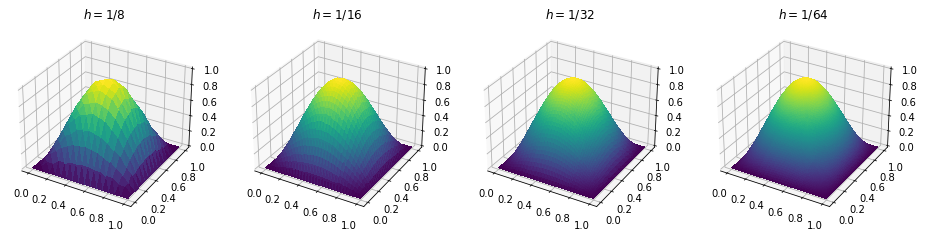

In [21]:
us = []
for mesh in meshes:
    x, y = SpatialCoordinate(mesh)
    f = sin(pi*x)*sin(pi*y)
    V = FunctionSpace(mesh, 'CG', degree=1)
    u = Function(V).interpolate(f)
    us.append(u)

m = min(4, n)
fig, ax = plt.subplots(1, 4, figsize=[4*4, 4], subplot_kw=dict(projection='3d'))
ax = ax.flat
for i in range(n):
    trisurf(us[i], axes=ax[i])
    ax[i].set_title(f'$h=1/{N*2**i}$')

### 投影到细网格上的空间中

目前 Firedrake 只能投影函数到相邻层的网格上 (由 MeshHierarchy 生成的网格), 和最密网格比较时可以多次投影, 直至最密网格, 然后比较结果.

下面我们仅比较相邻层的误差

In [22]:
errors = []
hs = []
for i, u in enumerate(us[:-1]):
    u_ref = us[i+1]
    u_inter = project(u, u_ref.function_space())
    error = errornorm(u_ref, u_inter)
    errors.append(error)
    hs.append(1/(N*2**i))

hs, errors

([0.125, 0.0625, 0.03125],
 [0.012284003199971324, 0.003100763810085325, 0.0007770614161052795])

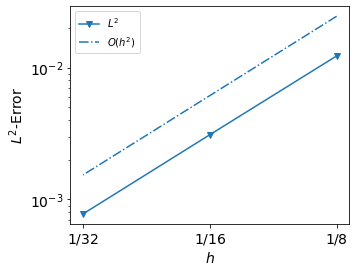

In [23]:
from intro_utils import plot_errors
plot_errors(hs, errors, expect_order=2)

### 插值到细网格上的空间中

+ VertexOnlyMesh
+ PointCloud: https://github.com/lrtfm/fdutils

#### Example of `PointCloud`


Interpolate function `f1` on mesh `m1` to function `f2` on mesh `m2` 

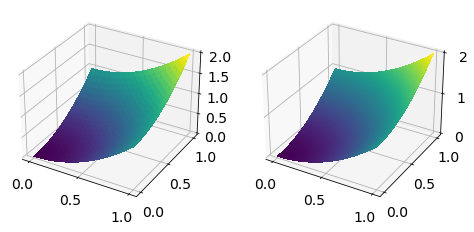

In [24]:
import firedrake as fd
from fdutils import PointCloud
from fdutils.tools import get_nodes_coords
import matplotlib.pyplot as plt

m1 = fd.RectangleMesh(10, 10, 1, 1)
V1 = fd.FunctionSpace(m1, 'CG', 2)
x, y = fd.SpatialCoordinate(m1)
f1 = fd.Function(V1).interpolate(x**2 + y**2)

m2 = fd.RectangleMesh(20, 20, 1, 1)
V2 = fd.FunctionSpace(m2, 'CG', 3)
f2 = fd.Function(V2)

points = get_nodes_coords(f2)
pc = PointCloud(m1, points, tolerance=1e-12)
f2.dat.data_with_halos[:] = pc.evaluate(f1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts1 = fd.trisurf(f1, axes=ax[0])
ts2 = fd.trisurf(f2, axes=ax[1])

#### 计算误差

In [25]:
from fdutils.tools import errornorm as my_errornorm

my_errors_0 = []
for i, u in enumerate(us[:-1]):
    # 和相邻层结果比较
    my_errors_0.append(my_errornorm(u, us[i+1], tolerance=1e-12))

my_errors_0

[0.012284003212205772, 0.003100763847789638, 0.0007770614201377909]

In [26]:
from fdutils.tools import errornorm as my_errornorm

my_errors = []
for i, u in enumerate(us[:-1]):
    # 和最密层结果比较
    my_errors.append(my_errornorm(u, us[-1], tolerance=1e-12))

my_errors

[0.015349062780286471, 0.0037181920308195534, 0.0007770614201377909]

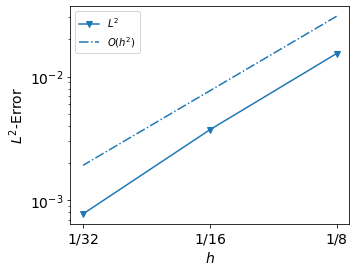

In [27]:
from intro_utils import plot_errors
plot_errors(hs, my_errors, expect_order=2)

## 网格尺寸和质量

### 网格尺寸

网格尺寸 `CellDiameter` 和 `CellSize` 一样, 均为最长边.

也可以直接用 `mesh.cell_sizes` , 这个函数是 `CellSize` 在连续空间 P1 的投影.

内切圆半径 `Circumradius`

__注__： 只能作用于线性网格

In [28]:
from firedrake import *

mesh = RectangleMesh(1, 1, 1, 1)
V = FunctionSpace(mesh, 'DG', 0)

d = CellDiameter(mesh)
d_int = Function(V).interpolate(d)

r = Circumradius(mesh)   # 内切圆半径
r_int = Function(V).interpolate(r)

size = mesh.cell_sizes

In [29]:
d_int.dat.data, size.dat.data, r_int.dat.data, 

(array([1.41421356, 1.41421356]),
 array([1.41421356, 1.41421356, 1.41421356, 1.41421356]),
 array([0.70710678, 0.70710678]))

In [30]:
CellDiameter?

Init signature: CellDiameter(domain)
Docstring:     
UFL geometry representation: The diameter of the cell, i.e.,
maximal distance of two points in the cell.
File:           ~/software/firedrake-mini-petsc/src/ufl/ufl/geometry.py
Type:           type
Subclasses:     


In [31]:
Circumradius?

Init signature: Circumradius(domain)
Docstring:      UFL geometry representation: The circumradius of the cell.
File:           ~/software/firedrake-mini-petsc/src/ufl/ufl/geometry.py
Type:           type
Subclasses:     


### 网格质量

仅作用于线性网格

In [32]:
from firedrake import *

def get_quality_3d(mesh):
    kernel = r'''
    void get_quality(double coords[4][3], double v[1], double q[1]){
        double a, b, c, p;
        double ls[6];
        double s, r, R, _tmp;
        double v1[3], v2[3], v3[3];
        int idx[6][2] = {{0, 1}, {2, 3}, {0, 2}, {1, 3}, {0, 3}, {1, 2}};
        int idx2[4][3] = {{0, 1, 2}, {0, 2, 3}, {1, 2, 3}, {0, 1, 3}};
        for (int i=0; i < 6; i++){
            _tmp = 0;
            for (int j=0; j < 3; j++){
                _tmp += pow(coords[idx[i][0]][j] - coords[idx[i][1]][j], 2.0);
            }
            ls[i] = sqrt(_tmp);
        }
        a = ls[0]*ls[1];
        b = ls[2]*ls[3];
        c = ls[4]*ls[5];
        p = (a + b + c)/2;

        s = 0;
        for (int i=0; i < 4; i++){
            for (int j = 0; j < 3; j++){
                v1[j] = coords[idx2[i][2]][j] - coords[idx2[i][0]][j];
                v2[j] = coords[idx2[i][2]][j] - coords[idx2[i][1]][j];
            }
            v3[0] =   v2[1]*v1[2] - v2[2]*v1[1];
            v3[1] = - v2[0]*v1[2] + v2[2]*v1[0];
            v3[2] =   v2[0]*v1[1] - v2[1]*v1[0];
            s += sqrt(pow(v3[0], 2.0) + pow(v3[1], 2.0) + pow(v3[2], 2.0))/2;
        }

        R = sqrt(p*(p-a)*(p-b)*(p-c))/v[0]/6.0;
        r = 3*v[0]/s;
        q[0] = r/R;
    }
    '''

    coords =  mesh.coordinates
    V = FunctionSpace(mesh, 'DG', 0)
    volume = Function(V).interpolate(CellVolume(mesh))
    quality = Function(V)

    cell_node_map = quality.cell_node_map()
    op2.par_loop(op2.Kernel(kernel, 'get_quality'), cell_node_map.iterset,
                 coords.dat(op2.READ, coords.cell_node_map()),
                 volume.dat(op2.READ, cell_node_map),
                 quality.dat(op2.WRITE, cell_node_map))

    return quality

def get_quality_2d(mesh):
    V = FunctionSpace(mesh, 'DG', 0)
    quality = Function(V)
    kernel = '''
    // B[2] - B[0], B[3] - B[1]
    // B[4] - B[0], B[5] - B[1]
    double S, a, b, c, R, r;
    S = fabs((B[5] - B[1])*(B[2] - B[0])  - (B[3] - B[1])*(B[4] - B[0]));
    a = sqrt(pow(B[2] - B[0], 2.) + pow(B[3] - B[1], 2.));
    b = sqrt(pow(B[4] - B[2], 2.) + pow(B[5] - B[3], 2.));
    c = sqrt(pow(B[0] - B[4], 2.) + pow(B[1] - B[5], 2.));
    R = a*b*c/(2*S);
    r = S/(a+b+c);
    A[0] = r/R;
    '''

    par_loop(kernel, \
             dx, \
             {'A': (quality, WRITE), 'B' :(mesh.coordinates, READ)})

    return quality

def get_quality_2d_surface(mesh):
    kernel = r'''
    void get_quality(double coords[3][3], double v[1], double q[1]){
        double p, _tmp, R, r, ls[3];
        double S = v[0];
        int idx[3][2] = {{0, 1}, {1, 2}, {0, 2}};
        for (int i=0; i < 3; i++){
            _tmp = 0;
            for (int j=0; j < 3; j++){
                _tmp += pow(coords[idx[i][0]][j] - coords[idx[i][1]][j], 2.0);
            }
            ls[i] = sqrt(_tmp);
        }
        p = (ls[0] + ls[1] + ls[2])/2;
        
        // S = sqrt(p*(p-ls[0])*(p-ls[1])*(p-ls[2]));
        R = ls[0]*ls[1]*ls[2]/(4*S);
        r = S/p;
        q[0] = r/R;
    }
    '''

    coords =  mesh.coordinates
    V = FunctionSpace(mesh, 'DG', 0)
    volume = Function(V).interpolate(CellVolume(mesh))
    quality = Function(V)

    cell_node_map = quality.cell_node_map()
    op2.par_loop(op2.Kernel(kernel, 'get_quality'), cell_node_map.iterset,
                 coords.dat(op2.READ, coords.cell_node_map()),
                 volume.dat(op2.READ, cell_node_map),
                 quality.dat(op2.WRITE, cell_node_map))
    return quality

__2d 和 3d__

In [33]:
mesh2d = RectangleMesh(1, 1, 1, 1)
mesh3d = UnitCubeMesh(1, 1, 1)

q2 = get_quality_2d(mesh2d)
q3 = get_quality_3d(mesh3d)

In [34]:
q2.dat.data, q3.dat.data

(array([0.41421356, 0.41421356]),
 array([0.23914631, 0.23914631, 0.23914631, 0.23914631, 0.23914631,
        0.23914631]))

__2d 正三角形__

In [35]:
from firedrake.petsc import PETSc
from pyop2.datatypes import IntType

cells = np.array([[0, 1, 2]], dtype=IntType)
coords = np.array([[0.0, 0.0],
                   [1.0, 0.0],
                   [1/2, np.sqrt(3)/2]])

plex = PETSc.DMPlex()
plex.createFromCellList(2, cells, coords)
mesh = Mesh(plex)
q_mesh = get_quality_2d(mesh)
q_mesh.dat.data

array([0.5])

__曲面网格__

In [36]:
mesh_surf = IcosahedralSphereMesh(1)
q_surf = get_quality_2d_surface(mesh_surf)
q_surf.dat.data

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [37]:
from firedrake.petsc import PETSc
from pyop2.datatypes import IntType

cells = np.array([[0, 1, 2]], dtype=IntType)
coords = np.array([[0.0, 0.0, 0.0],
                   [1.0, 0.0, 0.0],
                   [1/2, np.sqrt(3)/2, 0.0]])

plex = PETSc.DMPlex()
plex.createFromCellList(2, cells, coords)
mesh = Mesh(plex, dim=3)
q_mesh = get_quality_2d_surface(mesh)
q_mesh.dat.data

array([0.5])

## 构造等参元

Firedrake 中坐标是通过函数 `Function` 给出的, 可以通过更改该函数的值来移动网格或者构造等参元对应的映射.

### 修改网格坐标 (移动网格)

坐标的存储 (numpy 数组)
```python
mesh = RectangleMesh(10, 10, 1, 1)
mesh.coordinates.dat.data
mesh.coordinates.dat.data_ro
mesh.coordinates.dat.data_with_halos
mesh.coordinates.dat.data_ro_with_halos
```

单进程运行时 `data` 和 `data_with_halos` 相同. 关于 `halos` 请参考 https://op2.github.io/PyOP2/mpi.html.

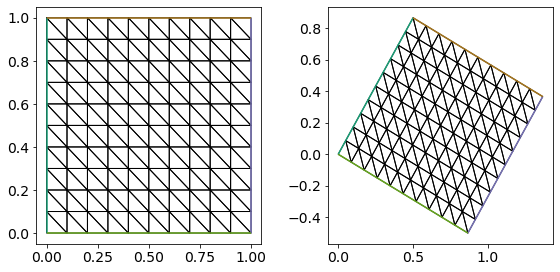

In [38]:
import numpy as np

# test_mesh = UnitDiskMesh(refinement_level=3)
test_mesh = RectangleMesh(10, 10, 1, 1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
handle = triplot(test_mesh, axes=ax[0])

theta = np.pi/6
R = np.array([[np.cos(theta), - np.sin(theta)], 
              [np.sin(theta),   np.cos(theta)]])

# test_mesh.coordinates.dat.datas[:] = test_mesh.coordinates.dat.data_ro[:]@R
test_mesh.coordinates.dat.data_with_halos[:] = test_mesh.coordinates.dat.data_ro_with_halos[:]@R

handle = triplot(test_mesh, axes=ax[1])
fig.tight_layout()

### 简单映射边界点

等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上. 以单位圆为例:

```python
def points2bdy(points):
    r = np.linalg.norm(points, axis=1).reshape([-1, 1])
    return points/r

def make_high_order_mesh_map_bdy(m, p):
    coords = m.coordinates
    V_p = VectorFunctionSpace(m, 'CG', p)
    coords_p = Function(V_p, name=f'coords_p{i}').interpolate(coords)
    
    bc = DirichletBC(V_p, 0, 'on_boundary')
    points = coords_p.dat.data_ro_with_halos[bc.nodes]
    coords_p.dat.data_with_halos[bc.nodes] = points2bdy(points)
    
    return Mesh(coords_p)
```

### 同时移动边界单元的内点

Reference: 
1. [M. Lenior, Optimal Isoparametric Finite Elements and Error Estimates For Domains Involving Curved Boundaries. SIAM. J. Numer. Anal. 23(3). 1986. pp 562--580.](https://epubs.siam.org/doi/10.1137/0723036)


等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上, 同时移动边界单元的内部自由度.

```python
def make_high_order_mesh_simple(m, p):
    if p == 1:
        return m

    coords_1 = m.coordinates
    coords_i = coords_1
    for i in range(2, p+1):
        coords_im1 = coords_i
        V_i = VectorFunctionSpace(m, 'CG', i)
        bc = DirichletBC(V_i, 0, 'on_boundary')
        coords_i = Function(V_i, name=f'coords_p{i}').interpolate(coords_im1)
        coords_i.dat.data_with_halos[bc.nodes] = \
            points2bdy(coords_i.dat.data_ro_with_halos[bc.nodes])

    return Mesh(coords_i)
```

__注__: 
这是一个简单的实现, 并不完全符合文献[1]中等参元映射构造方式, 一个完整的实现方式见文件 [make_mesh_circle_in_rect.py](make_mesh_circle_in_rect.py) 中的函数 `make_high_order_coords_for_circle_in_rect`: 该函数实现了内部具有一个圆形界面的矩形区域上的等参映射.

### 数值实验

精确解为 $u =  1 - (x^2 + y^2)^{3.5}$

In [39]:
%run possion_convergence_circle.py -max_degree 3 -exact "1 - (x[0]**2 + x[1]**2)**3.5"

Exact solution:  1 - (x[0]**2 + x[1]**2)**3.5 

p = 1; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.21472147 0.10953982 0.05505367]
            orders: [0.99748178 1.00490702]
    Rel. L2 errors: [0.02973733 0.00764636 0.00192565]
            orders: [2.01284532 2.01420929]

p = 2; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.02567607 0.00823192 0.00274559]
            orders: [1.68586184 1.60384374]
    Rel. L2 errors: [0.00804638 0.00197793 0.00048968]
            orders: [2.07953304 2.0391775 ]

p = 2; Use iso: True; Only move bdy: False.
    Rel. H1 errors: [0.02049517 0.00516031 0.0012846 ]
            orders: [2.04399704 2.03112667]
    Rel. L2 errors: [1.32436157e-03 1.65779996e-04 2.05806815e-05]
            orders: [3.07968268 3.04739627]

p = 3; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.01465085 0.00517696 0.00182789]
            orders: [1.54172011 1.52063516]
    Rel. L2 errors: [0.00786267 0.00195543 0.00048687]
          

## 间断有限元方法

### UFL 符号
+ `+`:  

    `u('-')`

+ `-`:  

    `u('+')`

+ avg:  

    `(u('+') + u('-'))/2`

+ jump: 
    
    `jump(u, n) = u('+')*n('+') + u('-')*n('-')`
    
    `jump(u) = u('+') - u('-')`

+ FacetNormal:

    边界法向

+ CellDiameter:
    
    网格尺寸

### UFL 测度
1. `ds` 外部边
2. `dS` 内部边

### 变分形式

\begin{equation}
\begin{aligned}
    \int_\Omega \nabla u \cdot \nabla v 
    &- \int_{EI} (\{\nabla u\}[vn] + [un]\{\nabla v\})
     - \frac{\alpha}{h}\int_{EI} [un][vn] \\
    &- \int_{EO} (v n \nabla u  + u n \nabla v)
     - \frac{\alpha}{h}\int_{EO} uv \\
    &- \int_\Omega f v   - \int_{\partial\Omega_N} g_N v = 0
\end{aligned}
\end{equation}
其中 $[vn] = v^+n^+ + v^-n^-, \{u\} = (u^+ + u^-)/2$

In [40]:
mesh = RectangleMesh(8, 8, 1, 1)

DG1 = FunctionSpace(mesh, 'DG', 1)
u, v = TrialFunction(DG1), TestFunction(DG1)

x, y = SpatialCoordinate(mesh)
f = sin(pi*x)*sin(pi*y)

h = Constant(2.0)*Circumradius(mesh)
alpha = Constant(1)
gamma = Constant(1)

n = FacetNormal(mesh)

a = inner(grad(u), grad(v))*dx \
  - dot(avg(grad(u)), jump(v, n))*dS \
  - dot(jump(u, n), avg(grad(v)))*dS \
  + alpha/avg(h)*dot(jump(u, n), jump(v, n))*dS \
  - dot(grad(u), v*n)*ds \
  - dot(u*n, grad(v))*ds \
  + gamma/h*u*v*ds

L = f*v*dx

u_h = Function(DG1, name='u_h')
bc = DirichletBC(DG1, 0, 'on_boundary')
solve(a == L, u_h, bcs=bc)

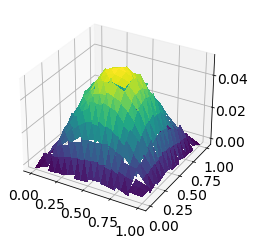

In [41]:
fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

### Positive and negative part of inner boundary

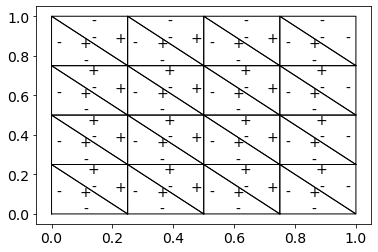

In [42]:
from firedrake import *
from firedrake.petsc import PETSc

import os, sys
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 14})

N = PETSc.Options().getInt('N', default=4)

m = RectangleMesh(N, N, 1, 1)
V = FunctionSpace(m, 'DG', 0)
Vc = VectorFunctionSpace(m, 'DG', 0)
V_e = FunctionSpace(m, 'HDivT', 0)
V_ec = VectorFunctionSpace(m, 'HDivT', 0)

x, y = SpatialCoordinate(m)
u = Function(V, name='u')
uc = Function(Vc).interpolate(m.coordinates)
u_e = Function(V_e, name='u_e')
u_ec = Function(V_ec).interpolate(m.coordinates)

ncell = len(u.dat.data_ro)

factor = 0.7
for i in range(ncell):
    cell = V.cell_node_list[i][0]
    u.dat.data_with_halos[:] = 0
    u.dat.data_with_halos[cell] = 1
    es = V_e.cell_node_list[i]
    cc = uc.dat.data_ro_with_halos[cell, :]
    
    vertex = m.coordinates.dat.data_ro_with_halos[
        m.coordinates.function_space().cell_node_list[i]
    ]
    vertex = np.vstack([vertex, vertex[0]])
    plt.plot(vertex[:, 0], vertex[:, 1], 'k', lw=1)
    
    for e in es:
        u_e.dat.data_with_halos[:] = 0
        u_e.dat.data_with_halos[e] = 1
        ec = u_ec.dat.data_ro_with_halos[e, :]
        dis = ec - cc
        
        v_p, v_m = assemble(u('+')*u_e('+')*dS), assemble(u('-')*u_e('-')*dS)
        _x = cc[0] + factor*dis[0]
        _y = cc[1] + factor*dis[1]

        plt.text(_x, _y, '+' if v_p > 0 else '-', ha='center', va='center')
        
rank, size = m.comm.rank, m.comm.size
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig(f'figures/dgflag_{size}-{rank}.pdf')

## Dirac Delta 函数

### 通过数值积分公式实现 dirac delta 函数

In [43]:
from firedrake import *

from firedrake.petsc import PETSc
from pyop2 import op2
from pyop2.datatypes import ScalarType
from mpi4py import MPI
import finat
import numpy as np

import matplotlib.pyplot as plt

set_level(CRITICAL) # Disbale warnings

class DiracOperator(object):
    def __init__(self, m, x0):
        """Make Dirac delta operator at point

        Args:
            m: mesh
            x0: source point

        Example:
            delta = DiracOperator(m, x0)
            f = Function(V)
            f_x0 = assemble(delta(f))
        """
        self.mesh = m
        self.x0 = x0
        self.operator = None
        
    def __call__(self, f):
        if self.operator is None:
            self._init()
        return self.operator(f)

    def _init(self):
        m = self.mesh
        x0 = self.x0
        V = FunctionSpace(m, 'DG', 0)
        cell_marker = Function(V, name='cell_marker', dtype=ScalarType)
        qrule = finat.quadrature.make_quadrature(V.finat_element.cell, 0)
        cell, X = m.locate_cell_and_reference_coordinate(x0, tolerance=1e-6)

        # c = 0 if X is None else 1
        n_cell_local = len(cell_marker.dat.data)
        if X is not None and cell < n_cell_local:
            c = 1
        else:
            c = 0

        comm = m.comm
        s = comm.size - comm.rank
        n = comm.allreduce(int(s*c), op=MPI.MAX)

        if n == 0:
            raise BaseException("Points not found!")

        k = int(comm.size - n) # get the lower rank which include the point x0

        if c == 1 and comm.rank == k:
            X[X<0] = 0
            X[X>1] = 1
            cell_marker.dat.data[cell] = 1
            comm.bcast(X, root=k)
        else:
            cell_marker.dat.data[:] = 0 # we must set this otherwise the process will hangup
            X = comm.bcast(None, root=k)


        cell_marker.dat.global_to_local_begin(op2.READ)
        cell_marker.dat.global_to_local_end(op2.READ)

        qrule.point_set.points[0] = X
        qrule.weights[0] = qrule.weights[0]/np.real(assemble(cell_marker*dx))

        self.operator = lambda f: f*cell_marker*dx(rule=qrule)


### 测试 `DiracOperator`

In [44]:
def test_dirca_delta_1D():
    test_mesh = IntervalMesh(8, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    source = Constant([x1,])
    delta = DiracOperator(test_mesh, source)

    x, = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**2)

    expected_value =  g.at([x1])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_1D()

value = 0.46648900000000026, expected value = 0.4664890000000005


In [45]:
def test_dirca_delta_2D():
    test_mesh = RectangleMesh(8, 8, 1, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    x2 = 0.333
    source = Constant([x1,x2])
    x0 = source
    delta = DiracOperator(test_mesh, source)

    x, y = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**3 + y**3)

    expected_value =  g.at([x1, x2])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_2D()

value = 0.3555380240000009, expected value = 0.355538024000001


### Dirac delta 函数的 L2 投影

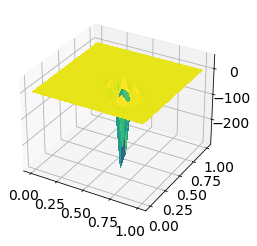

In [46]:
test_mesh = RectangleMesh(10, 10, 1, 1)
V = FunctionSpace(test_mesh, 'CG', 3)
delta = DiracOperator(test_mesh, [0.638, 0.33])
bc = DirichletBC(V, 0, 'on_boundary')
u, v = TrialFunction(V), TestFunction(V)
sol = Function(V)
solve(u*conj(v)*dx == delta(conj(v)), sol, bcs=bc)

fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(sol, axes=ax) # 为什么负值那么大？

### 求解源项为 Dirca delta 函数的 Possion 方程

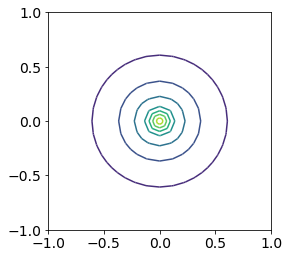

In [47]:
x0 = [0, 0]
# N = 500
# m = SquareMesh(N, N, 1)

m = UnitDiskMesh(refinement_level=3)

V = FunctionSpace(m, 'CG', 1)

v = TestFunction(V)
u = TrialFunction(V)

a = inner(grad(u), grad(v))*dx
L = DiracOperator(m, x0)(v)
u = Function(V, name='u')

bc = DirichletBC(V, 0, 'on_boundary')

solve(a == L, u, bcs=bc)

# solve(a == L, u)
fig, ax = plt.subplots(figsize=[4, 4])
ts = tricontour(u, axes=ax)

## 自由度映射关系

### Cell node map

+ `V.dim()`: Number of dofs
+ `V.cell_node_list`: an array of cell node map (same with `V.cell_node_map().values`)

In [48]:
mesh = RectangleMesh(8, 8, 1, 1)
V = FunctionSpace(mesh, 'CG', 1)

# the global numers of the dofs in the first 2 elements
for i in range(2): 
    print(f"cell {i}: ", V.cell_node_list[i]) 

cell 0:  [0 1 2]
cell 1:  [1 2 3]


__Example: 第一个三角形的坐标__

In [49]:
coords = mesh.coordinates
V_c = coords.function_space()
dof_numbers = V_c.cell_node_list[0]

for i in dof_numbers:
    print(f"vertex {i}:", coords.dat.data_ro_with_halos[i])

vertex 0: [0. 0.]
vertex 1: [0.    0.125]
vertex 2: [0.125 0.   ]


### Finite element (dofs on reference cell)

In [50]:
V = FunctionSpace(mesh, 'CG', 2)
element = V.finat_element

print("cell: ",  element.cell)
print("degree: ", element.degree)

cell:  <FIAT.reference_element.UFCTriangle object at 0x7fb809f74460>
degree:  2


In [51]:
element.entity_dofs() # dofs for every entity (vertex, edge, face, volume)

{0: {0: [0], 1: [1], 2: [2]}, 1: {0: [3], 1: [4], 2: [5]}, 2: {0: []}}

## Adaptive Finite Element Methods

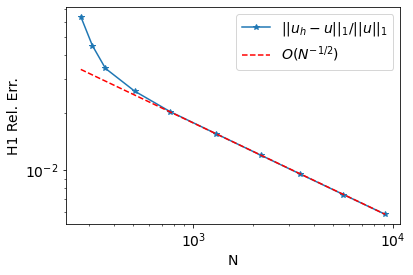

In [52]:
# %load adapt_possion.py
from firedrake import *
from firedrake.petsc import PETSc, flatten_parameters
from pyop2.datatypes import IntType, RealType, ScalarType, \
                            as_cstr, as_ctypes, as_numpy_dtype

import numpy as np
import matplotlib.pyplot as plt

def solve_possion(mesh, u_handle, f_handle):
    x = SpatialCoordinate(mesh)
    u_e = u_handle(x)
    f = f_handle(x)
    
    V = FunctionSpace(mesh, 'CG', 1)
    u, v = TrialFunction(V), TestFunction(V)

    L = inner(f, v)*dx
    a = inner(grad(u), grad(v))*dx
    sol = Function(V, name='u_h')
    
    bc = DirichletBC(V, u_e, 'on_boundary')

    solve(a == L, sol, bcs=bc)
    
    err = errornorm(u_e, sol, norm_type='H1')/norm(u_e, norm_type='H1')
    
    return sol, err


def estimate(mesh, sol, u_handle, f_handle, alpha, beta):
    x = SpatialCoordinate(mesh)
    u_e = u_handle(x)
    f = f_handle(x)

    V_eta_K = FunctionSpace(mesh, 'DG', 0)
    V_eta_e = FunctionSpace(mesh, 'HDivT', 0)

    phi_K = TestFunction(V_eta_K)
    phi_e = TestFunction(V_eta_e)

    phi = div(grad(sol)) + f
    g = jump(grad(sol), FacetNormal(mesh))

    ksi_K = assemble(inner(phi**2, phi_K)*dx)
    ksi_e = assemble(inner(g**2, avg(phi_e))*dS)
    ksi_outer = assemble(inner((sol-u_e)**2, phi_e)*ds)

    h_e = assemble(phi_e*ds)
    h_K = Function(V_eta_K).interpolate(CellDiameter(mesh))
    
    eta_K = assemble_eta_K_op2(ksi_K, ksi_e, ksi_outer, h_K, h_e, alpha=alpha, beta=beta)
    # eta_K2 = assemble_eta_K_py(ksi_K, ksi_e, ksi_outer, h_K, h_e, alpha=alpha, beta=beta)
    # assert np.allclose(eta_K.dat.data_ro_with_halos, eta_K2.dat.data_ro_with_halos)
    
    return eta_K


def assemble_eta_K_py(ksi_K, ksi_e, ksi_outer, h_K, h_e, alpha, beta):
    V_eta_K = ksi_K.function_space()
    V_eta_e = ksi_e.function_space()
    
    cell_node_list_K = V_eta_K.cell_node_list
    cell_node_list_e = V_eta_e.cell_node_list    
    
    ne_per_cell = V_eta_e.cell_node_list.shape[1]

    s1 = np.zeros_like(ksi_K.dat.data_ro_with_halos)
    for i in range(0, ne_per_cell):
        s1 += ksi_e.dat.data_ro_with_halos[cell_node_list_e[:, i]]
    
    s2 = np.zeros_like(ksi_K.dat.data_ro_with_halos)
    for i in range(0, ne_per_cell):
        s2 += h_e.dat.data_ro_with_halos[cell_node_list_e[:, i]] * ksi_outer.dat.data_ro_with_halos[cell_node_list_e[:, i]]

    eta_K = Function(V_eta_K)
    eta_K.dat.data_with_halos[:] = np.sqrt(
        alpha * h_K.dat.data_ro_with_halos**2 * ksi_K.dat.data_ro_with_halos \
        + beta * h_K.dat.data_ro_with_halos * s1
        # + beta * (h_K.dat.data_ro_with_halos * s1 + s2)
    )
    
    return eta_K


def assemble_eta_K_op2(ksi_K, ksi_e, ksi_outer, h_K, h_e, alpha, beta):
    V_eta_K = ksi_K.function_space()
    V_eta_e = ksi_e.function_space()

    kernel_str = '''
void assemble_eta_K({type} eta_K[1], {type} ksi_K[1], {type} ksi_e[{dim}], 
              {type} ksi_outer[{dim}], {type} h_K[1], {type} h_e[{dim}]) 
{{
    {type} s = 0;
    {type} s1 = 0;
    for (int i = 0; i < {dim}; i++) s += ksi_e[i];
    for (int i = 0; i < {dim}; i++) s1 += h_e[i]*ksi_outer[i];
    eta_K[0] = sqrt({alpha}*h_K[0]*h_K[0]*ksi_K[0] + {beta}*h_K[0]*s);
}}
'''.format(type=as_cstr(ScalarType), dim=V_eta_e.cell_node_list.shape[1],
           # double or complex       number of edges per element
           alpha=alpha, beta=beta)
    
    kernel = op2.Kernel(kernel_str, 'assemble_eta_K')
    
    eta_K = Function(ksi_K)
    iterset = eta_K.cell_node_map().iterset
    with PETSc.Log.Event("assemble_eta_K"):
        op2.par_loop(kernel, iterset, \
                     eta_K.dat(op2.WRITE, eta_K.cell_node_map()), \
                     ksi_K.dat(op2.READ, ksi_K.cell_node_map()), \
                     ksi_e.dat(op2.READ, ksi_e.cell_node_map()), \
                     ksi_outer.dat(op2.READ, ksi_outer.cell_node_map()), \
                     h_K.dat(op2.READ, h_K.cell_node_map()),
                     h_e.dat(op2.READ, h_e.cell_node_map())
                    )

    return eta_K


def mark_cells(mesh, eta_K, theta):
    plex = mesh.topology_dm
    cell_numbering = mesh._cell_numbering

    if plex.hasLabel('adapt'):
        plex.removeLabel('adapt')

    with eta_K.dat.vec_ro as vec:
        eta = vec.norm()
        eta_max = vec.max()[1]

    cell_node_list_K = eta_K.function_space().cell_node_list
    tol = theta*eta_max
    with PETSc.Log.Event("ADD_ADAPT_LABEL"):
        plex.createLabel('adapt')
        cs, ce = plex.getHeightStratum(0)
        for i in range(cs, ce):
            c = cell_numbering.getOffset(i)
            dof  = cell_node_list_K[c][0]
            if eta_K.dat.data_with_halos[dof] > tol:
                plex.setLabelValue('adapt', i, 1)

    return plex


def adapt_possion():
    opts = PETSc.Options()
    opts.insertString('-dm_plex_transform_type refine_sbr')

    def u_exact(x):
        x1, x2 = x
        r = sqrt(x1**2 + x2**2)
        theta = atan_2(x2, x1)
        u = r**(2/3)*sin(2*theta/3)
        return u
    
    def f_handle(x):
        return Constant(0)
    
    mesh = Mesh('gmsh/Lshape.msh')
    ret = []
    for i in range(10):
        if i != 0:
            with PETSc.Log.Event("ADAPT"):
                new_plex = plex.adaptLabel('adapt')
            mesh = Mesh(new_plex)
        sol, err = solve_possion(mesh, u_exact, f_handle)
        eta_K = estimate(mesh, sol, u_exact, f_handle, alpha=0.15, beta=0.15)
        plex = mark_cells(mesh, eta_K, theta=0.2)
        
        ndofs = sol.function_space().dim()
    
        ret.append((ndofs, err))
        
    return ret

def plot_adapt_result(ret):
    data = np.array(ret)
    if COMM_WORLD.rank == 0:
        plt.figure()
        # plt.rcParams.update({'font.size': 12})
        plt.loglog(data[:, 0], data[:, 1], '*-', label=r'$||u_h - u||_1/||u||_1$')

        plt.loglog(data[:, 0], data[:, 0]**(-1/2)*data[-1, 1]/data[-1, 0]**(-1/2), 'r--', label='$O(N^{-1/2})$')
        plt.savefig('figures/adapt_solver.pdf')
        plt.xlabel('N')
        plt.ylabel('H1 Rel. Err.')
        plt.legend()


if __name__ == '__main__':
    ret = adapt_possion()
    plot_adapt_result(ret)

# NS 方程

Navier-Stocks 方程:
\begin{equation}
\left\{
\begin{aligned}
&\partial_t u - \mu\Delta u + (u\cdot\nabla)u + \nabla p = f, && {\rm in} \quad \Omega\times(0, T]\\
&\nabla\cdot u = 0, && {\rm in} \quad \Omega\times(0, T]
\end{aligned}
\right.
\end{equation}

初边值条件
\begin{equation}
\left\{
\begin{aligned}
& u = 0, && {\rm on} \quad \partial\Omega\times(0, T] \\
&u_0 = (y, -x) &&{\rm in} \quad \Omega\quad{\rm at}\quad t = 0\\
\end{aligned}
\right.
\end{equation}


In [53]:
from firedrake import *

mu = 1
T = 0.25

N_S = 16
N_T = 128

tau = T/N_T
h = 1/N_S

mesh = RectangleMesh(N_S, N_S, 1, 1)

x = SpatialCoordinate(mesh)
# u_0 = as_vector((x[1] - 0.5, - x[0] + 0.5))
u_0 = as_vector((x[1], - x[0]))
f = as_vector([0, -1])

## 函数空间

采用 MINI 元, 即 P1 $\times$ P1b.

P1b 由 P1 加上 Bubble 组成.

`NodalEnrichedElement`, `EnrichedElement`

`VectorFunctionSpace` 构造向量空间

In [54]:
cell = mesh.ufl_cell()
tdim = cell.topological_dimension()

# Mini element: P1 X P1b
P1 = FiniteElement("CG", cell, 1)
B = FiniteElement("B", cell, tdim+1)
P1b = P1 + B # or P1b = NodalEnrichedElement(P1, B)

V_u = VectorFunctionSpace(mesh, P1b)
V_p = FunctionSpace(mesh, "CG", 1)
V = MixedFunctionSpace([V_u, V_p])

## 弱形式

\begin{equation}
\left\{
\begin{aligned}
&\frac{1}{\tau}(u^n - u^{n-1}, v) + \mu(\nabla u^n, \nabla v) + ((u^n\cdot\nabla)u^n, v) - (p^n, \nabla\cdot v) = (f^n, v)\\
&(q, \nabla\cdot u^n) = 0
\end{aligned}
\right.
\end{equation}

+ `TrialFunctions`, `TestFunctions`: 

  以 `tuple` 返回函数空间中的试验/测试函数,

  主要用于 `MixedFunctionSpace`.
  
+ `split`, Function.split
    + `split`: 以索引的方式获取 `MixedFunctionSpace` 中函数的分量 (保留 UFL 关联信息, 用于定义变分形式)
    + `Function.split`: 以存储共享的方式获取分量 (生成新的变量, 只是共享原存储空间)

由于该问题是非线性问题, 我们打算用 `NonlinearVariationalSolver` 进行求解, 所以下面定义 `w` 使用了 `Function` 而不是 `TrialFunction`/`TrialFunctions`.

In [55]:
w = Function(V) # u and p
u, p = split(w)

v, q = TestFunctions(V)

w_nm1 = Function(V)
u_nm1, p_nm1 = w_nm1.split()
u_nm1.rename('u_h') # for visualization in paraview
p_nm1.rename('p_h')

Re = Constant(mu)

F = \
      Constant(1/tau)*inner(u - u_nm1, v)*dx \
    + Re*inner(grad(u+u_nm1)/2, grad(v))*dx \
    + inner(dot(grad(u), (u+u_nm1)/2), v)*dx \
    - p*div(v)*dx \
    + div(u)*q*dx \
    - inner(f, v)*dx

## 定义 Solver

类似于纯 Neumann 问题, 我们将使用 `nullspace` 参数.

注意下面混合空间中, 边界条件和 `nullspace` 的定义.

In [56]:
bc = DirichletBC(V.sub(0), 0, 'on_boundary')
nullspace = MixedVectorSpaceBasis(V, [V.sub(0), VectorSpaceBasis(constant=True)])

problem = NonlinearVariationalProblem(F, w, bcs=bc)  # F = 0
solver = NonlinearVariationalSolver(problem,
                                    options_prefix='ns',
                                    solver_parameters=None, # {'snes_converged_reason': None, 'snes_max_it': 100},
                                    nullspace=nullspace
                                   )

## 时间循环和保存结果到 `pvd` 文件

In [57]:
from tqdm.notebook import tqdm # progress bar

u_, p_ = w.split()

output = File('pvd/ns-equation.pvd')

u_nm1.project(u_0)
output.write(u_nm1, p_nm1, time=0)

for i in  tqdm(range(N_T)):
    t = tau*(i+1)
    
    solver.solve()
    
    u_nm1.assign(u_)
    p_nm1.assign(p_)

    output.write(u_nm1, p_nm1, time=t)

  0%|          | 0/128 [00:00<?, ?it/s]

### Constant 用于时间依赖的表达式

In [58]:
from firedrake import *
mesh = RectangleMesh(10, 10, 1, 1)
C1 = Constant(0)

x, y = SpatialCoordinate(mesh)
expr = C1*(x+y)

v = []
for i in range(5):
    t = i*0.1
    C1.assign(t)
    v.append(
        assemble(expr*dx)
    )

print(v)

[0.0, 0.09999999999999991, 0.19999999999999982, 0.29999999999999966, 0.39999999999999963]


## ParaView 可视化计算结果

Pipeline 和 Filter

### 二维结果 (surf 图)

Filter: Wrap by scalar

### 选择部分区域显示

View -> Find Data



# 多进程并行 (MPI)

在终端使用 `mpiexec -n <np>` 运行 python 文件即可:
    
```bash
mpiexec -n 2 python myscript.py
```

## Run code parallelly in jupyter

我们使用 `ipyparallel` 介绍并行程序的一些内容, 需要先安装 `ipyparallel`

In [59]:
import ipyparallel as ipp
import os

cluster = ipp.Cluster(profile="mpi", n=2)
client = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

## Communicator

In [60]:
%%px --block
from firedrake import *
from firedrake.petsc import PETSc
from mpi4py import MPI

mesh = RectangleMesh(8, 8, 1, 1)
PETSc.Sys.syncPrint(mesh.comm.rank, mesh.comm.size)
PETSc.Sys.syncFlush()

[stdout:0] 0 2
1 2


In [61]:
%%px --block

PETSc.Sys.syncPrint(COMM_WORLD.rank, COMM_WORLD.size)
PETSc.Sys.syncFlush()

[stdout:0] 0 2
1 2


有些时候需要在某个进程上, 做指定的操作或运算, 如只在第0个进程上画图

```python
if COMM_WORLD.rank == 0:
    plot(...)
```

## 并行输出

[intro_utils.py](intro_utils.py)

In [62]:
%%px --block 
from firedrake import *
from firedrake.petsc import PETSc
from mpi4py import MPI

PETSc.Sys.Print('This is first line (from rank 0)')

[stdout:0] This is first line (from rank 0)


In [63]:
%%px --block 
PETSc.Sys.syncPrint('This is second line (from all rank)')
PETSc.Sys.syncFlush()

[stdout:0] This is second line (from all rank)
This is second line (from all rank)


In [64]:
%%px --block
print('This msg from all rank')

[stdout:1] This msg from all rank


[stdout:0] This msg from all rank


# PETSc

[Introduction to PETSc](https://learn.tacc.utexas.edu/mod/page/view.php?id=96)

DOC: https://web.corral.tacc.utexas.edu/CompEdu/pdf/pcse/petsc_p_course.pdf

PETSc git repo: [petsc4py demo](https://gitlab.com/petsc/petsc/-/tree/main/src/binding/petsc4py/demo)

PETSc 目录中有用的工具, 如 `h5dump`, `petsc_gen_xdmf.py`, `PetscBinaryIO.py` 等.

在 PETSc 环境中, 运行如下命令添加这些工具所在路径到 `PATH`:
```bash
export PATH="$PATH:$PETSC_DIR/lib/petsc/bin"
export PATH="$PATH:$PETSC_DIR/${PETSC_ARCH-default}/bin"
```

在激活的 firedrake 环境下, 可以运行如下命令的输出, 添加这些工具所在路径到环境变量 `PATH`.
```bash
python -c "from firedrake import *; \
           import os; \
           PETSC_DIR = os.environ['PETSC_DIR']; \
           PETSC_ARCH = os.environ['PETSC_ARCH']; \
           print('\nRun the follwoing code to add petsc/bin to path:\n'); \
           print(f'  export PATH=\"\$PATH:{PETSC_DIR}/lib/petsc/bin\"'); \
           print(f'  export PATH=\"\$PATH:{PETSC_DIR}/{PETSC_ARCH}/bin\"'); \
           print('');"
```


## Vector and Matirx

保存矩阵到文件: [matvecio.py](https://gitlab.com/petsc/petsc/-/blob/main/src/binding/petsc4py/demo/binary-io/matvecio.py)

In [65]:
from firedrake import *
from firedrake.petsc import PETSc

test_mesh = RectangleMesh(nx=4, ny=4, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx

In [66]:
A = assemble(a)
b = assemble(L)
type(A), type(b)

(firedrake.matrix.Matrix, firedrake.function.Function)

### Matrix

In [67]:
type(A.petscmat)

petsc4py.PETSc.Mat

单进程运行且矩阵不大时, 可以把 PETSc 矩阵转换为 `numpy` 数组

In [68]:
import numpy as np
from scipy.sparse import csr_matrix

m, n = A.petscmat.getSize()
indptr, indices, data = A.petscmat.getValuesCSR()

A_numpy = csr_matrix((data, indices, indptr), shape=(m, n)).toarray()

In [69]:
A.petscmat.getRow(0), A_numpy[0, :]

((array([0, 1, 2], dtype=int32), array([ 1. , -0.5, -0.5])),
 array([ 1. , -0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ]))

### Vector

In [70]:
with b.dat.vec_ro as vec:
    print(type(vec))

<class 'petsc4py.PETSc.Vec'>


### ISLocalToGlobalMapping

Create a local to global map

In [71]:
import firedrake as fd
from firedrake.petsc import PETSc
from pyop2.datatypes import IntType, ScalarType
import numpy as np


rank = COMM_WORLD.rank

owned_sz = np.array(rank+3, dtype=IntType)
offset = np.empty_like(owned_sz)
COMM_WORLD.Scan(owned_sz, offset)
offset -= owned_sz
indices = np.arange(offset, offset + owned_sz, dtype=IntType)


lgmap = PETSc.LGMap()
lgmap.create(indices, bsize=1, comm=COMM_WORLD)
lgmap.view()

ISLocalToGlobalMapping Object: 1 MPI process
  type not yet set
[0] 0 0
[0] 1 1
[0] 2 2


## KSP

自定义 KSP 进行线性方程组求解请参考 PETSc 的文档

1. 求解完成需要检查是否收敛

In [72]:
from firedrake.petsc import OptionsManager, PETSc
from firedrake.solving_utils import KSPReasons

A = PETSc.Mat()
A.create(PETSc.COMM_WORLD)
A.setSizes([2, 2])
A.setType('aij') # sparse
# A.setPreallocationNNZ(4)
A.setUp()
A.setValue(1, 0, 1)
A.setValue(0, 1, np.inf) # to make the solver failed
A.assemble()

ksp = PETSc.KSP().create()
ksp.setOperators(A) # solve A*x=b by ksp.solve(b,x)

om = OptionsManager(
    {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'ksp_view': None,
        'pc_factor_mat_solver_type': 'mumps',
        'ksp_error_if_not_converged': None,
    },
    options_prefix='test')
om.set_from_options(ksp)

x, b = A.createVecs()
b.setValue(0, 1)
# ksp.view()
with om.inserted_options():
    try:
        ksp.solve(b, x)
    except Exception as e:
        r = ksp.getConvergedReason()
        reason = KSPReasons[r]
        print(f'ksp do not converged: {reason}')
        print(e)
        _e = e

ksp do not converged: ITERATING
error code 76
[0] KSPSolve() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/ksp/ksp/interface/itfunc.c:1048
[0] KSPSolve_Private() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/ksp/ksp/interface/itfunc.c:803
[0] KSPSetUp() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/ksp/ksp/interface/itfunc.c:394
[0] PCSetUp() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/ksp/pc/interface/precon.c:963
[0] PCSetUp_LU() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/ksp/pc/impls/factor/lu/lu.c:128
[0] MatLUFactorNumeric() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/mat/interface/matrix.c:3131
[0] MatFactorNumeric_MUMPS() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/mat/impls/aij/mpi/mumps/mumps.c:1653
[0] Error in external library
[0] Error reported by MUMPS in numerical factorization phase: INFOG(1)=-10, INFO(2)=1


## DMPlex

并行时, 网格会被划分成不同的块, 分配到各个进程.

网格由 `PETSc` 中的 `DMPlex` 管理.

DMPlex Reference:

1. [Lange, M., Mitchell, L., Knepley, M. G., & Gorman, G. J. Efficient mesh management in firedrake using PETSC DMPLEX. SISC, 2016, 38(5), S143-S155.]( https://epubs.siam.org/doi/10.1137/20M1332748)
2. 
[Hapla, V., Knepley, M. G., Afanasiev, M., Boehm, C., van Driel, M., Krischer, L., & Fichtner, A. Fully parallel mesh I/O using PETSc DMPlex with an application to waveform modeling. SISC, 2021, 43(2), C127-C153.](https://epubs.siam.org/doi/abs/10.1137/15M1026092)

### Load mesh file and view (petsc4py)

In [73]:
import sys
import petsc4py
petsc4py.init(sys.argv)

from petsc4py import PETSc
import numpy as np

dm = PETSc.DMPlex().createFromFile('gmsh/Lshape.msh', plexname='test')
dm.view()

# hdf5 for load
viewer = PETSc.Viewer().createHDF5('data/Lshape.h5', mode='w')
viewer(dm)

# hdf5 for visualization:
# You can generate xdmf file from this file by
#     `petsc/lib/petsc/bin/petsc_gen_xdmf.py`
# Then load the xdmf file to paraview to visualize the mesh.
viewer = PETSc.Viewer().createHDF5('data/Lshape_xdmf.h5', mode='w')
viewer.pushFormat(viewer.Format.HDF5_XDMF)
viewer(dm)
viewer.popFormat()

# vtk file
viewer = PETSc.Viewer().createVTK('data/Lshape.vtk', mode='w')
viewer(dm)

# draw on X window
# viewer = PETSc.Viewer().createDraw()
# viewer(dm)

DM Object: test 1 MPI process
  type: plex
test in 2 dimensions:
  Number of 0-cells per rank: 274
  Number of 1-cells per rank: 755
  Number of 2-cells per rank: 482
Labels:
  celltype: 3 strata with value/size (0 (274), 3 (482), 1 (755))
  depth: 3 strata with value/size (0 (274), 1 (755), 2 (482))


In [74]:
# since the petsc_draw is not in petsc4py, we use options to save the images

opts = PETSc.Options()
opts_old = opts.getAll()
opts.insertString('-dm_view draw:tikz:data/Lshape.tex')
dm.viewFromOptions('-dm_view')

### View mesh of firedrake by DMPlex

In [75]:
%%px --block 
from firedrake import *

mesh = RectangleMesh(8, 8, 1, 1)
mesh.topology_dm.view()

[stdout:0] DM Object: firedrake_default_topology 2 MPI processes
  type: plex
firedrake_default_topology in 2 dimensions:
  Number of 0-cells per rank: 45 45
  Number of 1-cells per rank: 108 108
  Number of 2-cells per rank: 64 64
Labels:
  depth: 3 strata with value/size (0 (45), 1 (108), 2 (64))
  celltype: 3 strata with value/size (0 (45), 1 (108), 3 (64))
  Face Sets: 2 strata with value/size (1 (8), 3 (8))
  exterior_facets: 1 strata with value/size (1 (16))
  interior_facets: 1 strata with value/size (1 (92))


## Star Forest

Reference:
  
  [1] J. Zhang et al., [The PetscSF Scalable Communication Layer](https://arxiv.org/pdf/2102.13018.pdf), IEEE Transactions on Parallel and Distributed Systems, 33(4), 2022. 

In [76]:
%%px --block
from firedrake import *
from firedrake.petsc import PETSc

from petsc4py import PETSc
import numpy as np

# 6--------7--------8
# |        |        |
# 3--------4--------5
# |        |        |
# 0--------1--------2

def test_SFDistributeSection():
    comm = COMM_WORLD
    if comm.rank == 0:
        cells = np.asarray(
            [[0, 1, 3],
             [1, 2, 4],
             [1, 4, 3],
             [2, 5, 4],
             [3, 4, 6],
             [4, 5, 7],
             [4, 7, 6],
             [5, 8, 7]], dtype=np.int32)
        coords = np.asarray(
            [[0. , 0. ],
             [0.5, 0. ],
             [1. , 0. ],
             [0. , 0.5],
             [0.5, 0.5],
             [1.0, 0.5],
             [0. , 1. ],
             [0.5, 1. ],
             [1. , 1. ]], dtype=np.double)
    else:
        cells = np.zeros([0, 3], dtype=np.int32)
        coords = np.zeros([0, 2], dtype=np.double)
    dim = 2
    plex = PETSc.DMPlex().createFromCellList(dim, cells, coords, comm=comm)
    rootSection = PETSc.Section().create(comm=comm)
    pStart, pEnd = plex.getHeightStratum(2)
    rootSection.setChart(*plex.getChart())
    for p in range(pStart, pEnd):
        rootSection.setDof(p, 1)
    rootSection.setUp()
    rootSection.viewFromOptions('-section_view')

    dplex = plex.clone()
    msf = dplex.distribute()

    if msf is None:
        PETSc.Sys.Print("Warning: plex has not been distributed!")
        return
    dplex.viewFromOptions('-dm_view')

    def isEqualSF(ssf0, ssf1):
        nroots0, local0, remote0 = ssf0.getGraph()
        nroots1, local1, remote1 = ssf1.getGraph()
        return (nroots0 == nroots1) \
                and np.array_equal(local0, local1) \
                and np.array_equal(remote0, remote1)

    remoteOffsets0, leafSection0 = msf.distributeSection(rootSection)
    ssf0 = msf.createSectionSF(rootSection, remoteOffsets0, leafSection0)

    remoteOffsets1, leafSection1 = msf.distributeSection(rootSection, None)
    ssf1 = msf.createSectionSF(rootSection, remoteOffsets1, leafSection1)

    leafSection2 = PETSc.Section()
    remoteOffsets2, leafSection2 = msf.distributeSection(rootSection, leafSection2)
    ssf2 = msf.createSectionSF(rootSection, remoteOffsets2, leafSection2)

    leafSection3 = PETSc.Section()
    remoteOffsets3, _ = msf.distributeSection(rootSection, leafSection3)
    ssf3 = msf.createSectionSF(rootSection, remoteOffsets3, leafSection3)

    leafSection4 = PETSc.Section().create(dplex.getComm())
    remoteOffsets4, leafSection4 = msf.distributeSection(rootSection, leafSection4)
    ssf4 = msf.createSectionSF(rootSection, remoteOffsets4, leafSection4)

    leafSection5 = PETSc.Section().create(dplex.getComm())
    remoteOffsets5, _ = msf.distributeSection(rootSection, leafSection5)
    ssf5 = msf.createSectionSF(rootSection, remoteOffsets5, leafSection5)

    assert isEqualSF(ssf0, ssf1)
    assert isEqualSF(ssf0, ssf2)
    assert isEqualSF(ssf0, ssf3)
    assert isEqualSF(ssf0, ssf4)
    ssf0.view()


In [77]:
%%px --block
# Add back after upgrad the firedrake
test_SFDistributeSection()

[stdout:0] PetscSF Object: 2 MPI processes
  type: basic
  [0] Number of roots=9, leaves=6, remote ranks=1
  [0] 0 <- (0,0)
  [0] 1 <- (0,1)
  [0] 2 <- (0,3)
  [0] 3 <- (0,4)
  [0] 4 <- (0,6)
  [0] 5 <- (0,7)
  [1] Number of roots=0, leaves=6, remote ranks=1
  [1] 0 <- (0,1)
  [1] 1 <- (0,2)
  [1] 2 <- (0,4)
  [1] 3 <- (0,5)
  [1] 4 <- (0,7)
  [1] 5 <- (0,8)
  MultiSF sort=rank-order


# Surface problems

## Line in plane

### Cell orientation for line in plane

In [78]:
from firedrake import *
import ufl
from ufl.classes import ReferenceGrad
import matplotlib.pyplot as plt

mesh = Mesh("gmsh/circle_1d.msh", dim=2)

V0 = FunctionSpace(mesh, 'DG', 0)

x = ufl.SpatialCoordinate(mesh)
f = Function(V0)
f.interpolate(ufl.dot(x, as_vector((-ReferenceGrad(x)[1, 0], ReferenceGrad(x)[0, 0]))))

cell_orientations = Function(V0)
cell_orientations.dat.data[:] = (f.dat.data_ro < 0)
mesh.topology._cell_orientations = cell_orientations

(-1.1167815329543878, 1.107321379242865, -1.114649962432814, 1.114649962432814)

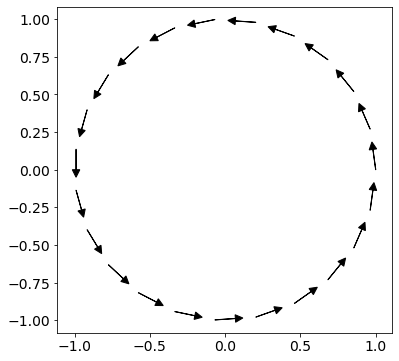

In [79]:
plt.figure(figsize=[6, 6])
Vc = mesh.coordinates.function_space()
for i, index in enumerate(Vc.cell_node_list):
    # print(index)
    coord = mesh.coordinates.dat.data_ro_with_halos[index]
    o = cell_orientations.dat.data_ro_with_halos[i]

    _x = coord[:, 0]
    _y = coord[:, 1]
    if o > 1/2:
        plt.arrow(_x[0], _y[0], (_x[1]-_x[0])/2, (_y[1]-_y[0])/2, head_width=0.05, head_length=0.05, fc='k', ec='k')
    else:
        plt.arrow(_x[1], _y[1], (_x[0]-_x[1])/2, (_y[0]-_y[1])/2, head_width=0.05, head_length=0.05, fc='k', ec='k')
    # plt.xlim([0.5, 1])
    # plt.ylim([-1/2, 1/2])
plt.axis('equal')

## Surface in 3D space

# Debug

## 常见问题

###  DIVERGED_LINEAR_SOLVE

The errors are like this.
```text
File "/home/yzz/firedrake/src/firedrake/firedrake/adjoint/solving.py", line 50, in wrapper
    output = solve(*args, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving.py", line 129, in solve
    _solve_varproblem(*args, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving.py", line 161, in _solve_varproblem
    solver.solve()
  File "/home/yzz/firedrake/src/firedrake/firedrake/adjoint/variational_solver.py", line 75, in wrapper
    out = solve(self, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/variational_solver.py", line 278, in solve
    solving_utils.check_snes_convergence(self.snes)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving_utils.py", line 139, in check_snes_convergence
    raise ConvergenceError(r"""Nonlinear solve failed to converge after %d nonlinear iterations.
firedrake.exceptions.ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE
```

Reasons for this:

1. You equation is not closed. May be you write wrong boundary conditions. Check the boundary condition carefully.
3. External package?
2. The resulting system is singular? (Maybe)
4. ...

We can add flag `-ksp_error_if_not_converged` to make PETSc print more infomation on the error. Below is an example of error `DIVERGED_LINEAR_SOLVE`

__Exmaple (Error of MUMPS)__

Below is an example on error occured in package mumps, we can look up the meaning of the error message in [doc of mumps](https://graal.ens-lyon.fr/MUMPS/index.php?page=doc)

```text
[63]PETSC ERROR: --------------------- Error Message --------------------------------------------------------------
[63]PETSC ERROR: Error in external library
[63]PETSC ERROR: Error reported by MUMPS in numerical factorization phase: INFOG(1)=-9, INFO(2)=26
[63]PETSC ERROR: See https://petsc.org/release/faq/ for trouble shooting.
[63]PETSC ERROR: Petsc Development GIT revision: v3.4.2-38777-g979cc68729  GIT Date: 2022-06-22 21:18:23 +0100
[63]PETSC ERROR: ../hsolver/hsolver.py on a default named AMAs4 by z2yang Tue Nov  8 16:03:18 2022
[63]PETSC ERROR: Configure options PETSC_DIR=/home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc PETSC_ARCH=default --download-ptscotch --with-zlib --download-hwloc --with-c2html=0 --download-eigen="/home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/eigen-3.3.3.tgz " --download-mpich --download-hdf5 --with-fortran-bindings=0 --with-64-bit-indices --download-bison --with-cxx-dialect=C++11 --download-metis --download-openblas --download-openblas-make-options="'USE_THREAD=0 USE_LOCKING=1 USE_OPENMP=0'" --download-pastix --download-mumps --with-shared-libraries=1 --with-scalar-type=complex --download-cmake --download-scalapack --with-debugging=0 --download-netcdf --download-superlu_dist --download-suitesparse --download-pnetcdf
[63]PETSC ERROR: #1 MatFactorNumeric_MUMPS() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/mat/impls/aij/mpi/mumps/mumps.c:1664
[63]PETSC ERROR: #2 MatLUFactorNumeric() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/mat/interface/matrix.c:3177
[63]PETSC ERROR: #3 PCSetUp_LU() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/ksp/pc/impls/factor/lu/lu.c:135
[63]PETSC ERROR: #4 PCSetUp() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/ksp/pc/interface/precon.c:993
[63]PETSC ERROR: #5 KSPSetUp() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/ksp/ksp/interface/itfunc.c:407
[63]PETSC ERROR: #6 KSPSolve_Private() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/ksp/ksp/interface/itfunc.c:843
[63]PETSC ERROR: #7 KSPSolve() at /home/z2yang/opt/firedrake-env/firedrake-complex-int64/src/petsc/src/ksp/ksp/interface/itfunc.c:1078
```

The doc of mumps on `INFOG(1) = -9` and `INCTL(14)`:

```text
The main internal real/complex workarray S is too small. If INFO(2) is positive, then the number
of entries that are missing in S at the moment when the error is raised is available in INFO(2).
If INFO(2) is negative, then its absolute value should be multiplied by 1 million. If an error –9
occurs, the user should increase the value of ICNTL(14) before calling the factorization (JOB=2)
again, except if LWK_USER is provided LWK_USER should be increased.
```

```text
ICNTL(14) corresponds to the percentage increase in the estimated working space.
Phase: accessed by the host both during the analysis and the factorization phases.
Default value: between 20 and 35 (which corresponds to at most 35 % increase) and depends on
               the number of MPI processes. It is set to 5 % with SYM=1 and one MPI process.
Related parameters: ICNTL(23)
Remarks: When significant extra fill-in is caused by numerical pivoting, increasing ICNTL(14)
         may help
```

We can set mumps' parameter through `-mat_mumps_icntl_<num>`, such as `-mat_mumps_icntl_14 35`,
see https://petsc.org/main/docs/manualpages/Mat/MATSOLVERMUMPS/ for details.

__Tips__

添加标志  `ksp_view`, `ksp_monitor`, `ksp_converged_reason`, `ksp_error_if_not_converged`.

### Currently no support for ReferenceGrad in CoefficientDerivative

在使用高阶网格时, 不能对单元边界法向进行求导.
对高阶网格的单元边界法向求导会有如下错误：

```txt
ufl.log.UFLException: Currently no support for ReferenceGrad in CoefficientDerivative.
```

In [80]:
from firedrake import *

def get_s12(mesh, u, v):
    n = FacetNormal(mesh)
    s1 = dot(n, dot(n, grad(grad(grad(u)))))
    s2 = dot(n, dot(n, grad(grad(grad(v)))))
    return s1, s2

def get_s12_v2(mesh, u, v):
    n = FacetNormal(mesh)
    s1 = dot(n, grad(dot(n, grad(grad(u)))))
    s2 = dot(n, grad(dot(n, grad(grad(v)))))
    return s1, s2

def test_grad_n(high_order_mesh=True, fun=get_s12):
    p = 3
    N = 10

    mesh = RectangleMesh(N, N, 1, 1)
        
    if high_order_mesh:
        V = VectorFunctionSpace(mesh, 'CG', 2)
        coords = Function(V).interpolate(mesh.coordinates)
        mesh = Mesh(coords)

    V = FunctionSpace(mesh, 'CG', p)

    u, v = TrialFunction(V), TestFunction(V)

    s1, s2 = fun(mesh, u, v)
    a = inner(grad(u), grad(v))*dx + inner(s1('+'), s2('+'))*dS + inner(s1('-'), s2('-'))*dS
    L = inner(Constant(0), v)*dx

    sol = Function(V)
    prob1 = LinearVariationalProblem(a, L, sol)
    solver = LinearVariationalSolver(prob)

    solver.solve()

for f in [get_s12, get_s12_v2]:
    for hom in [False, True]:
        try:
            test_grad_n(high_order_mesh=hom, fun=f)
            print(f.__name__, f': High order mesh: {hom}, ', "TEST OK!")
        except Exception as e:
            print(f.__name__, f': High order mesh: {hom}, ', "TEST ERROR: ", e)

get_s12 : High order mesh: False,  TEST ERROR:  name 'prob' is not defined
get_s12 : High order mesh: True,  TEST ERROR:  name 'prob' is not defined
get_s12_v2 : High order mesh: False,  TEST ERROR:  name 'prob' is not defined
get_s12_v2 : High order mesh: True,  TEST ERROR:  Currently no support for ReferenceGrad in CoefficientDerivative.


### PyErr_Occurred

```python
python: src/petsc4py.PETSc.c:348918: __Pyx_PyCFunction_FastCall: Assertion `!PyErr_Occurred()' failed.
```

This may caused by your python code (with pragrammer error, such as undefined variables) called by PETSc

__Tips__

在程序开始添加如下代码, 可能会有更详细信息
```python
from firedrake.petsc import PETSc
PETSc.Sys.popErrorHandler()
```

## 调试 Python 代码
运行中抛出异常, 定位出错代码, 检查相关的变量是否有异常值存在. 例如在 Jupyter notebook 中, `%debug` 可打开调试器, 检查相关变量.

## 调试 C 代码 (gdb)

由于 firedrake 基于 PETSc 进行网格管理和线性方程组求解, 有时出错会在 PETSc 中, 例如运行如下代码:

TODO: 找个示例, 这个示例不行
```python
# filename: test.py
import sys
import petsc4py
petsc4py.init(sys.argv)
from petsc4py import PETSc
if PETSc.COMM_WORLD.rank == 0:
    PETSc.Vec().create(comm=PETSc.COMM_SELF).view()
```
出错信息如下:
```bash
$ python test.py
Vec Object: 1 MPI process
  type not yet set
Traceback (most recent call last):
  File "test.py", line 7, in <module>
    PETSc.Vec().create(comm=PETSc.COMM_SELF).view()
  File "PETSc/Vec.pyx", line 140, in petsc4py.PETSc.Vec.view
petsc4py.PETSc.Error: error code 56
[0] VecView() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/vec/vec/interface/vector.c:715
[0] No support for this operation for this object type
[0] No method view for Vec of type (null)
```


这时可以使用 gdb 等调试工具. 

### gdb 命令行说明

```bash
gdb [options] --args executable-file [inferior-arguments ...]
```

### 参数 (options)
1. `-ex COMMAND`: 执行 gdb 命令
2. `--args exe [exe-args]` 传递参数给 exe
3. `--pid <pid>` 调试正在运行的程序

### gdb 命令:
1. `bt`: 查看函数调用栈
2. `run`: 运行可执行文件
3. `l`: 查看代码
4. `p`: 打印变量


### 示例 (调试 `test.py`)

```bash
$ gdb  -ex run --args $(which python3) test.py
```

## 并行程序调试

### `PETSc` 的参数 `-start_in_debugger`

Reference: 

1. https://petsc.org/main/docs/manualpages/Sys/PetscInitialize/
2. https://petsc.org/main/docs/manualpages/Sys/PetscSetDebugTerminal/

可以选择使用 `PETSc` 的参数 `-start_in_debugger` 给每个进程启动调试器如下:
```bash
mpiexec -n 3 $(which python) test.py  -start_in_debugger
```
默认会启动多个 xterm 窗口. 

_Notes_: 修改 xterm 窗口显示效果 (Ref: http://www.futurile.net/2016/06/14/xterm-setup-and-truetype-font-configuration/)

```shell
$ cat ~/.Xdefaults
xterm*faceName: Monospace
xterm*faceSize: 12
xterm*foreground: rgb:a8/a8/a8
xterm*background: rgb:00/00/00
```

### 工具 `tmux-mpi`


Reference: https://github.com/firedrakeproject/firedrake/wiki/Parallel-MPI-Debugging-with-tmux-mpi

另外我们也可以选择使用工具 `tmux-mpi`. 

#### 安装 tmux-mpi

1. 安装 tmux 
    
    ```bash
    sudo apt-get install tmux
    ```

2. 安装 dtach (tmux-mpi 依赖)

    先编译 dtach, 然后拷贝二进制文件到某个在 PATH 中的路径, 如 $HOME/bin.

    ```bash
    git clone https://github.com/crigler/dtach
    cd dtach
    ./configure
    make
    cp dtach $HOME/bin
    ```

    运行 `which dtach` 确认安装是否成功
    
3. 安装 tmux-mpi

    使用 pip 安装
    
    ```bash
    pip install --upgrade --no-cache-dir git+https://github.com/wrs20/tmux-mpi@master
    ```


#### 调试命令

1. 启动调试器

    ```bash
    tmux-mpi 3 gdb -ex run --args $(which python) test.py
    ```


2. Attach 到相应的的伪终端, 每个进程一个窗口. (这里是 tmux 的一个 session, 有多个 window)
    
    ```bash
    tmux attach -t tmux-mpi
    ```


3. 使用 gdb 调试命令调试

# Profiling

Reference:

1. https://www.firedrakeproject.org/optimising.html
2. https://petsc.org/main/docs/manual/profiling/
3. https://petsc.org/main/docs/manualpages/Sys/PetscInitialize/
4. https://petsc.org/main/docs/manualpages/Profiling/PetscLogView/

## `log_view`

1. `-log_view [:filename]`  Prints summary of log information

2. `-log_view :filename.py:ascii_info_detail`  Saves logging information from each process as a Python file

3. `-log_view :filename.xml:ascii_xml`  Saves a summary of the logging information in a nested format (see below for how to view it)

4. `-log_view :filename.txt:ascii_flamegraph`  Saves logging information in a format suitable for visualising as a Flame Graph (see below for how to view it)

5. `-log_view_memory`  Also display memory usage in each event

6. `-log_view_gpu_time`   Also display time in each event for GPU kernels (Note this may slow the computation)

7. `-log_all`   Saves a file Log.rank for each MPI rank with details of each step of the computation

8. `-log_trace [filename]`   Displays a trace of what each process is doing

### Flame graph

运行代码时加上选现 `-log_view :profile.txt:ascii_flamegraph`, 将会生成文件 `profile.txt`, 该文件会记录某些代码块的运行时间, 可用于性能分析. 可以通过在线工具 https://www.speedscope.app/ 可视化该文件. 示例代码如下:

```bash
python test.py -log_view :profile.txt:ascii_flamegraph
```


可以通过 `PETSc.Log.Event` 和 `PETSc.Log.EventDecorator` 添加自定义事件, 用于测量代码块的运行事件. 如果如上运行代码, 事件名称和运行时间将会记录在上述 `profile.txt` 中.

1. `PETSc.Log.Event`

    ```python
    from firedrake.petsc import PETSc

    with PETSc.Log.Event("foo"):
        do_something_expensive()
    ```

2. `PETSc.Log.EventDecorator`

    ```python
    from firedrake.petsc import PETSc

    @PETSc.Log.EventDecorator("foo")
    def do_something_expensive():
        ...
    ```

### `-log_view :profile.txt`

TODO